In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from math import ceil, floor
from matplotlib.colors import LogNorm

In [2]:
fits_filex='hlsp_frontier_model_abell2744_williams_v4_x-pixels-deflect.fits'
fits_filey='hlsp_frontier_model_abell2744_williams_v4_y-pixels-deflect.fits'
img_file='hlsp_frontier_model_abell2744_williams_v4_kappa.fits'
mag_file='hlsp_frontier_model_abell2744_williams_v4_z01-magnif.fits'
hdul = fits.open(fits_filex)
hdul1 = fits.open(fits_filey)
hdul_mag = fits.open(mag_file)
hdul_img = fits.open(img_file)


In [3]:
datax = hdul[0].data

datay = hdul1[0].data

data_img = hdul_img[0].data

#array_data = np.zeros((datax.shape[0],datax.shape[1]))
#array_data[100:160, 100:160]=datax[100:160, 100:160]

data_mag = hdul_mag[0].data
hdul.close()
hdul1.close()
hdul_img.close()

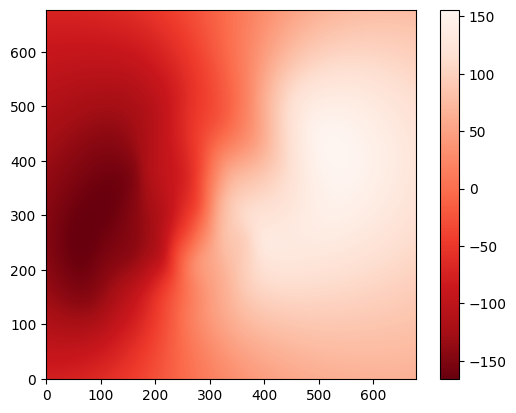

In [4]:
plt.imshow(datax, cmap='Reds_r')
plt.gca().invert_yaxis()
plt.colorbar()

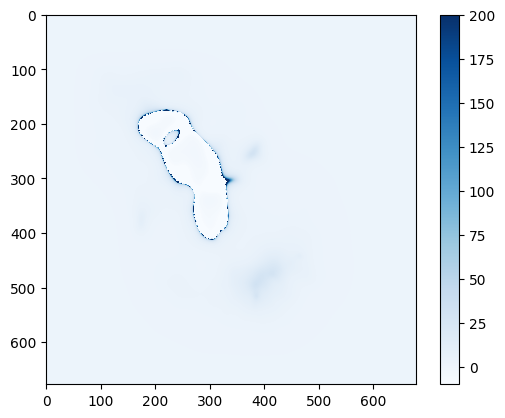

In [5]:
plt.imshow(data_mag, cmap='Blues',vmin=-10, vmax=200)
plt.colorbar()


5 199


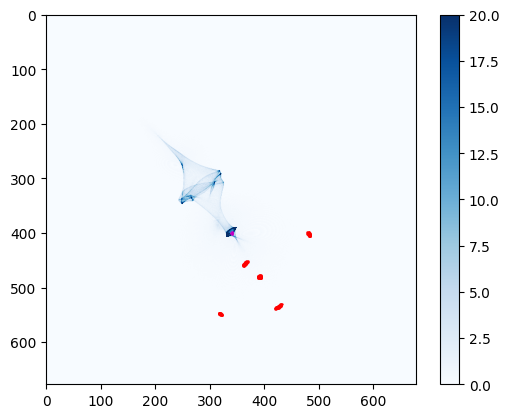

In [28]:
size = datax.shape[0]

array_test = np.zeros((size,size))
img_coord_in_src_coord = [[[] for _ in range(678)] for _ in range(678)]
for i in range(0,678):
    for j in range(0,678):
        ycoord = i-datay[i,j]
        xcoord = j-datax[i,j]
        ydec = ycoord%1
        xdec = xcoord%1
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        #array_test[ceil(ycoord),ceil(xcoord)] += data_img[i,j]*ydec*xdec
        #array_test[ceil(ycoord),floor(xcoord)] += data_img[i,j]*ydec*(1-xdec)
        #array_test[floor(ycoord),ceil(xcoord)] += data_img[i,j]*(1-ydec)*xdec
        array_test[yfloor,xfloor] += data_img[i,j]*(1-ydec)*(1-xdec)
        #img_coord_in_src_coord[floor(ycoord)][floor(xcoord)].append([i,j])


#gaussian circle
'''mean = [260, 330] #(x,y)
cov = [[40, 0], [0, 40]]

# Generate a grid of (x, y) coordinates
x, y = np.meshgrid(np.linspace(0, size, size), np.linspace(0, size, size))

# Generate a 2D Gaussian distribution over the grid
d = np.dstack([x, y])
gaussian_circle = np.exp(-0.5 * (np.einsum('...k,kl,...l->...', d - mean, np.linalg.inv(cov), d - mean)))
circle_coords = np.argwhere(gaussian_circle > 0.5)

# radius
from scipy.ndimage import distance_transform_edt as distance
radius = max(circle_coords[:,1])-mean[0]
print(f'Radius: {radius}')'''


#normal circle
radius = 1
center = (340 , 400)  

x, y = np.meshgrid(range(size), range(size))
circle = ((x - center[0])**2 + (y - center[1])**2) <= radius**2
circle_coords = np.argwhere(circle > 0) #(y,x)

plt.scatter(circle_coords[:,1],circle_coords[:,0],s=0.5, c='magenta')


scatterx, scattery = [], []
n=0

#specific method for perfect circle
for i in range(size):
    for j in range(size):
        ycoord = i-datay[i,j]
        xcoord = j-datax[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        dist = np.sqrt((ycoord-center[1])**2+(xcoord-center[0])**2)
        if dist <= radius:
            scatterx.append(j)
            scattery.append(i)
            n+=1
            

plt.scatter(circle_coords[:,1],circle_coords[:,0],s=0.5, c='m')

'''for (i,j) in circle_coords:
    
    for point in img_coord_in_src_coord[i][j]:
        n+=1
        scatterx.append(point[1])
        scattery.append(point[0])'''


plt.scatter(scatterx,scattery,s=0.5, c='r')
plt.imshow(array_test, cmap='Blues', vmax=20)
plt.colorbar()

print(len(circle_coords), n)

Magnification: [7.0, 9.0, 8.4, 10.0, 5.4]
Number of pixels: [35, 45, 42, 50, 27]


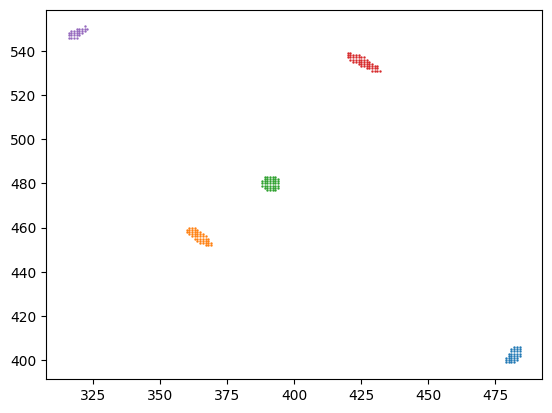

In [29]:
#magnification
from sklearn.cluster import DBSCAN
coordinates = []
for i in range(0, len(scatterx)):
    coordinates.append([scatterx[i], scattery[i]])
coordinates = np.array(coordinates)

# Apply DBSCAN clustering
# eps and min_samples need to be chosen based on your specific data
dbscan = DBSCAN(eps=3, min_samples=5).fit(coordinates)

# Extract labels
labels = dbscan.labels_

# Separate coordinates into arrays for each image
images = {}
for label in set(labels):
    if label != -1:  # Ignore noise points
        images[f"Image_{label}"] = coordinates[labels == label]

# images now contains separate arrays for each detected image
# convert the dictionary images to list
images = list(images.values())

for i in range(0, len(images)):
    plt.scatter(images[i][:,0], images[i][:,1], s=0.5)

m=[]
for i in range(0, len(images)):
    mag = len(images[i])/len(circle_coords)
    m.append(mag)
print(f'Magnification: {m}')
print(f'Number of pixels: {[np.sum(len(images[i])) for i in range(0, len(images))]}')

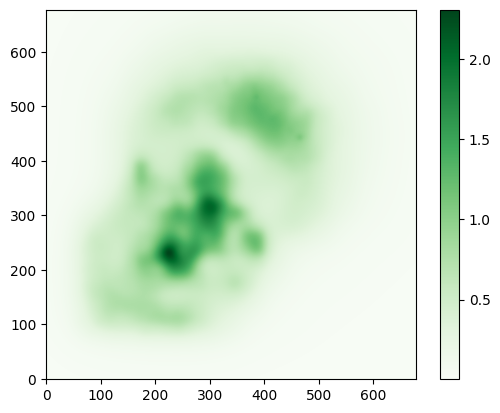

In [16]:
plt.imshow(data_img, cmap='Greens')
plt.colorbar()
plt.gca().invert_yaxis()